## Travel Agent

AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input

search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation


search weather forcasting
1. get current weather
2. get weather forcast


search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range


calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
  

currency_converion
1. get exchnage rate
2. convert currancy
  

Itinery generation
1. get day plan
2. crete full itinery


create Trip Summary
  

Retun complete traval plan


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import operator
from typing import Annotated, Sequence, List,Optional, Any, Dict
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import tool
import requests
from langchain_community.utilities import GoogleSerperAPIWrapper, GooglePlacesAPIWrapper
from langchain_community.tools import  DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from datetime import date, datetime

## Config

In [2]:
## Config Class

class Config:
    
    def __init__(self):
        self.weather_api_key = os.getenv('OPENWEATHERMAP_API_KEY')
        self.serper_api_key = os.getenv('SERPER_API_KEY')
        self.tavily_api_key = os.getenv('TAVILY_API_KEY')
        self.openai_api_key = os.getenv('OPENAI_API_KEY')
    
    def get_api_keys(self):
        return {
            'weather_api_key': self.weather_api_key,
            'serper_api_key': self.serper_api_key,
            'tavily_api_key': self.tavily_api_key,
            'openai_api_key': self.openai_api_key
        }

### Check_Weather Class to get current weather forcast.

In [3]:
class Check_Weather:
    def __init__(self,api_key: str):
        self.api_key = api_key
        self.base_url = 'https://api.openweathermap.org/data/2.5/'
        
    def get_weather(self, city: str) -> Dict[str, Any]:
        ''' Get the current weather for a given city.'''
        try:
            self.url = f'{self.base_url}weather?q={city}&units=metric&appid={self.api_key}'
            response = requests.get(self.url)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f'Error: {str(e)}')
            return {'Error': str(e)}
        
    def get_forecast(self, city: str, days:int) -> Dict[str, Any]:
        ''' Get the weather forecast for a given city.'''
        try:
            num_intervals = days * 8  # OpenWeatherMap API returns 8 forecasts per day
            self.url = f'{self.base_url}/forecast?q={city}&cnt={num_intervals}&units=metric&appid={self.api_key}'
            
            response = requests.get(self.url)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f'Error: {str(e)}')
            return {'Error': str(e)}
    

## Currency Convertion using https://frankfurter.dev/

In [4]:

class Currency_Converter:
    
    def __init__(self):
        self.base_url = 'https://api.frankfurter.dev/v1/latest'
        
    def convert_currency(self,amount:float, from_currency: str, to_currency: str ) -> float:
        ''' Convert currency from one to another.'''
        try:
            url = f'{self.base_url}?amount={amount}&from={from_currency}&to={to_currency}'
            response = requests.get(url)
            response.raise_for_status()
            result = response.json()
            return result['rates'][to_currency]
        except Exception as e:
            print(f'Error: {str(e)}')
            return None
        

## Calculator for expense calculations

In [5]:
class Calculator:
    
    def add(self,*costs: float) -> float:
        '''
        Sum all the given costs.

        Returns:
            float: Sum all costs.
        '''
        return sum(costs)
    
    def multiply(self, *costs:float) -> float:
        '''
        Multiply given costs.
        
        Returns:
            float: Product of all costs.
        '''
        result = 1
        for cost in costs:
            result *=cost
        return result
    
    
    @staticmethod
    def calculate_daily_budget(total_cost: float, days: int) -> float:
        '''
        Calculate the daily budget based on total cost and number of days.
        Args:
            total_cost (float): Total cost of the trip.
            days (int): Number of days for the trip.
        Returns:
            float: Daily budget for the trip.
        '''
        if days==0:
            return 0.0
        return total_cost / days
    

## Travel Search

In [6]:
class Travel_Planner_Tools:
    
    def __init__(self, config: dict):
        self.config = config
        self.weather_service = Check_Weather(api_key=self.config.get('weather_api_key'))
        self.currency_converter  = Currency_Converter()
        self.calculator = Calculator()
        
        ## Initializing search tools
        self.duckduck_search = DuckDuckGoSearchRun()
        
        try:
            self.serp_search = GoogleSerperAPIWrapper(serper_api_key=self.config.get('serper_api_key'))
        except Exception as e:
            print(f'Error initializing GoogleSerperAPIWrapper: {str(e)}')
            self.serp_search = None
        
        try:
            self.tavily_search = TavilySearchResults(max_results=5, tavily_api_key=self.config.get('tavily_api_key'))
        except Exception as e:
            print(f'Error initializing TavilySearchResults: {str(e)}')
            self.tavily_search = None
            
        ## Initializing llm
        try:
            self.llm = ChatOpenAI(model = 'o3-mini', openai_api_key = self.config.get('openai_api_key'))
        except Exception as e:
            print(f'Error initializing ChatOpenAI: {str(e)}')
            self.llm = None
        
        
        if self.llm:
            self.tools = self._travel_planning_tools()
            self.llm_with_tools = self.llm.bind_tools(self.tools)
        else:
            self.tools=[]
            self.llm_with_tools = None
        

        
        ## Initializing tools
    def _travel_planning_tools(self) -> List:
        '''
        Initialize and return the list of tools for travel planning.
        Returns:
            List: List of tools for travel planning.
        '''
        ## Defining Pydantic model or structured input to get_day_plan tool
        class DayPlanItem(BaseModel):
            time: str = Field(...,description='Estimated time of the activity (e.g.,9:00 AM - 11:00 AM).')
            activity: str = Field(..., description = 'Description of the activity (e.g., Visit Eiffel Tower, Lunch at Le Comptoir).')
            location: Optional[str] = Field(None, description= 'Specific location or address of the activity.')
            notes: Optional[str] = Field(None, description='Any sepcific notes or recommendations for the activity (e.g., Book tickets in advance, Try the local cuisine).')
            estimated_cost: Optional[str] = Field(None, description='Estimated cost of the activity (e.g., 20 USD, 50 EUR).')
            
        class DayPlanInput(BaseModel):
            date: str = Field(..., description="The date for which the plan is being generated (YYYY-MM-DD).")
            day_number: int = Field(..., description="The number of the day in the itinerary (e.g., 1 for Day 1).")
            plan_items: List[DayPlanItem] = Field(..., description="A list of planned activities for the day, in chronological order, following the DayPlanItem schema.")
            summary: Optional[str] = Field(None, description="A brief summary of the day's plan.")
            weather_forcast: Optional[str] = Field(None, description="Weather forecast for the day, if available.")
        
        ## Defining the main input model for the full itinerary input
        class FullItinearyInput(BaseModel):
            destination: str=Field(...,description='Main destination city for the trip')
            start_date: str =Field(...,description='Start date of the trip in YYYY-MM-DD format')
            end_date: str=Field(...,description='End date of the trip in YYYY-MM-DD format')
            total_days: str=Field(...,description='Total number of days for the trip')
            daily_plans: List[str]=Field(...,description='A list of formatted strings where each string represents a daily plan generated by the get_day_pan tool.')
            overall_summary: Optional[str] = Field(None,description='An optional overall summary of the trip')
            budget_information: Optional[str] = Field(None,description='An optional budget information for the trip (e.g., Mid-range, Estimated total : XX)')
            overall_weather_summary: Optional[str] =Field(None,description='Optional overall current weather and forcast information of the destination')
        
        @tool
        def search_attraction(city: str) -> str:
            ''' Search for top tourist attractions in a city.
            Args:
                city (str): Name of the city to search for attractions.
            Returns:
                str: Search results for top tourist attractions in the city.
            '''
            query = f'Top tourist attractions in {city}'
            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results:
                        return f'Top attraction in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (attraction): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result:
                            return f'Top attraction in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top attraction in {city} not found'

        
        @tool
        def search_restaurant(city: str) -> str:
            ''' Search for top restaurants in a city.
            Args:
                city (str): Name of the city to search for restaurants.
            Returns:
                str: Search results for top restaurants in the city.
            '''
            query = f'Top restaurants in {city}'
            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results:
                        return f'Top restaurant in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (restaurant): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result:
                            return f'Top restaurant in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top restaurant in {city} not found'
                
        @tool
        def search_activity(city: str) -> str:
            ''' Search for top activities in a city.
            Args:
                city (str): Name of the city to search for activities.
            Returns:
                str: Search results for top activities in the city.
            '''
            query = f'Top activities in {city}'
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results:
                        return f'Top activities in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (activity): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result:
                            return f'Top activities in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top activities in {city} not found'
        
        @tool
        def search_transport(city: str) -> str:
            ''' Search for means of transportation in a city.
            Args:
                city (str): Name of the city to search for transportation options.
            Returns:
                str: Search results for means of transportation in the city.
            '''
            query = f'Means of transport in {city}'
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: DuckDuckGoSearchRun
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results:
                        return f'Means of transport in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (transport): {str(e)}')
            try:
                if self.duckduck_search:
                    results = self.duckduck_search.invoke(query)
                    if results:
                        return f'Means of transport in {city} : {results}'
            except Exception as e:
                print(f'Error in DuckDuckGo Search: {str(e)}')
            return f'Means of transport in {city} not found'
        
        @tool
        def get_current_weather(city:str) -> str:
            ''' Get the current weather afor a city.
            Args:
                city (str): Name of the city to get weather information.
            Returns:
                str: Current weather for the city.
            '''
            try:
                current_weather = self.weather_service.get_weather(city)
                if current_weather and 'main' in current_weather and 'weather' in current_weather:                                 
                    current_description=current_weather['weather'][0]['description']
                    current_temp  = current_weather['main']['temp']
                    return f'Current weather in {city} : {current_temp}°C, {current_description}'
                return f'Current weather in {city} not found'
            except Exception as e:
                print(f'Error getting current weather: {str(e)}')
                return f'Current weather in {city} not found due to error'
                
                
        @tool
        def get_weather_forcast(city:str, days: int = 5) -> Dict[str, Any]:
            ''' Get the weather forecast for a city.
            Args:
                city (str): Name of the city to get weather information.
                days (int): Number of days for the forecast
            Returns:
                Dict[str, Any]: Raw Json weather forecast data.
            '''
            try:
                weather_forecast = self.weather_service.get_forecast(city, days)  
                if weather_forecast and 'list' in weather_forecast:
                      return weather_forecast
                return {"error": f'Weather forecast for {city} not found'}
                '''
                summary = []
                for i in weather_forecast['list']:
                    date = i['dt_txt']
                    temperature = i['main']['temp']
                    description = i['weather'][0]['description']
                    summary.append(f'{date} :  {temperature}°C,{description}')
                return f'Weather forecast for {city}:\n' + '\n'.join(summary)'''
                
            except Exception as e:
                print(f'Error getting weather forecast: {str(e)}')
                return f'Weather forecast for {city} not found due to error'
        
        @tool
        def search_hotels(city: str, check_in_date: Optional[str]=None, check_out_date: Optional[str]=None) -> str:
            ''' Search for top hotels in a city.
            Args:
                city (str): Name of the city to search for hotels.
                check_in_date (str, optional): Check-in date in YYYY-MM-DD format.
                check_out_date (str, optional): Check-out date in YYYY-MM-DD format.
            Returns:
                str: Search results for hotels in the city, including price and booking availability if found.
            '''
            query = f'Mid range hotels in {city}'
            if check_in_date and check_out_date:
                query += f' from {check_in_date} to {check_out_date}'
            query += '. Name of hotel and current price per night booking availability'            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: DuckDuckGoSearchRun
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results:
                        return f'Hotels in {city} : {results}'
            except Exception as e:
                print(f"Error in Serper Search: {str(e)}")
            try:
                if self.duckduck_search:
                    results = self.duckduck_search.invoke(query)
                    if results:
                        return f'Hotels in {city} : {results}'
            except Exception as e:
                print(f'Error in DuckDuckGo Search: {str(e)}')
            return f'Hotels in {city} not found'
        
        @tool
        def hotel_cost(price_per_night: float, days:int) -> float:
            ''' Calculate the total cost of hotel stay.
            Args:
                price_per_night (float): Price per night for the hotel.
                days (int): Number of days for the hotel stay.
            Returns:
                float: Total cost of the hotel stay.
            '''
            return self.calculator.multiply(price_per_night, days)
        
        @tool
        def add_costs(*costs: float) -> float:
            '''
            Add multiple costs together
            
            Args:
                *costs (float): List of costs to be sumed up
                
            Returns:
                float: Total cost
            '''
            return self.calculator.add(*costs)
        
        @tool
        def multiply_costs(*costs: float) -> float:
            '''
            Multiply multiple costs together
            
            Args:
                *costs (float): List of costs to be multiplies together
                
            Returns:
                float: Total cost
            '''
            return self.calculator.multiply(*costs)
        
        
        @tool
        def calculate_daily_budget(total_cost: float, days:int) -> float:
            '''
            Calculate the daily budget based on total cost and no of days.
            
            Args:
                total_cost (float): Total cost of the budget
                days (int) : Number of days
                
            Returns:
                float: Daily budget amount
            '''
            return self.calculator.calculate_daily_budget(total_cost,days)
        
        
        @tool
        def convert_currency(amount: float,from_currency: str, to_currency: str ) -> float:
            ''' Convert currency from one to another.
            Args:
                amount (float): Amount to convert.
                from_currency (str): Currency to convert from.
                to_currency (str): Currency to convert to.                
            Returns:
                float: Converted amount in the target currency.
            '''
            return self.currency_converter.convert_currency(amount,from_currency, to_currency )
        
        @tool(args_schema= DayPlanInput)
        def get_day_plan(date: str, day_number: int, plan_items: List[DayPlanItem], summary: Optional[str] = None,weather_forecast: Optional[str] = None) -> str:
            '''
            Creates a structured daily itinerary plan based on list of activities.
            Args:
                date ( str): Specific date for the day's plan (YYYY-MM-DD)
                day_number (int): Day number in the itinerary (e.g., 1 for Day 1).
                plan_items (List[DayPlanItem]): A list of dictionaries, where each dictionary
                                                represents an activity with 'time', 'activity',
                                                'location', 'notes', and 'estimated_cost' keys.
                                                Each item should conform to the DayPlanItem schema.
                summary (Optional[str]): A brief summary of the day's plan.
                weather_forecast (Optional[str]): The weather forecast for this specific day.
            Returns:
                str: A formatted string representing the daily itinerary plan.
            '''
            plan_output = [f"---Day {day_number} ({date})---"]
            if summary:
                plan_output.append(f"Summary: {summary}")
            if weather_forecast:
                plan_output.append(f'Weather for the Day {day_number}: {weather_forecast}')
            plan_output.append("\n")
            
            for item in plan_items:
                plan_output.append(f"  {item.get('time', 'Time N/A')}: {item.get('activity','Activity N/A')}")
                if item.get('location'):
                    plan_output.append(f"   Location: {item['location']}")
                if item.get('estimated_costs'):
                    plan_output.append(f"   Estimated Cost: {item['estimated_costs']}")
                if item.get('notes'):
                    plan_output.append(f"   Notes: {item['notes']}")
                plan_output.append("")
            plan_output.append("---------------------------------\n")
            return "\n".join(plan_output)
        
        
        @tool(args_schema=FullItinearyInput)
        def create_full_itinerary(destination: str, start_date: str, end_date: str, total_days: int, daily_plans: List[str], 
                               overall_summary: Optional[str] = None, budget_information: Optional[str] = None, 
                               overall_weather_summary: Optional[str] = None) -> str:
            '''
            Generates a full itinerary for the trip based on the information provided.
            Args:
                destination (str): Main destination city for the trip.
                start_date (Str): Start date of the trip in YYYY-MM-DD format.
                end_Date (str): End date of the trip in YYYY-MM-DD format.
                total_days (int): Total number of days of the trip.
                daily_plans (List[str]): A list of formatted strings where each string represents a daily plan generated by the get_day_plan tool.
                overall_summary (Optional[str]): An optional overall summary of the trip.
                budget_information (Optional[str]): An optional budget information for the trip (e.g., Mid-range, Estimated total : XX).
                overall_weather_summary (Optional[str]): Optional overall current weather and forecast information of the destination.
            Returns:
                str: A formatted string representing the full itinerary for the trip.
            '''
            full_itinerary_output= []
            full_itinerary_output.append(f'***** Your Trip to {destination} *****')
            full_itinerary_output.append(f"Dates: {start_date} to {end_date} ({total_days} days)")
            if overall_summary:
                full_itinerary_output.append(f"Overview: {overall_summary}")
            if budget_information:
                full_itinerary_output.append(f"Budget : {budget_information}")
            if overall_weather_summary:
                full_itinerary_output.append(f"Overall Weather Outlook: {overall_weather_summary}")
            full_itinerary_output.append("\n"+"="*50+"\n")
            
            for plans in daily_plans:
                full_itinerary_output.append(plans)
                
            full_itinerary_output.append("\n"+"="*50+"\n")
            full_itinerary_output.append("**This itinerary is generated by AI. Please verify the information before making any bookings.**\n")
            full_itinerary_output.append("---End of Trip Plan---")
            
            return "\n".join(full_itinerary_output)    
            

        
        return [
            search_attraction,
            search_restaurant,
            search_activity,
            search_transport,
            get_current_weather,
            get_weather_forcast,
            search_hotels,
            hotel_cost,
            add_costs,
            multiply_costs,
            calculate_daily_budget,
            convert_currency,
            get_day_plan,
            create_full_itinerary
        ]
                  

You are a highly skilled AI Travel Agent and Expense Planner, expert at creating detailed, user-centric itineraries for any city worldwide using real-time data.

**CORE DIRECTIVE: Deliver a COMPLETE, ACTIONABLE, and HIGHLY DETAILED travel plan in one comprehensive response. Absolutely do NOT use placeholders like "I'll prepare," "hold on," or similar deferring phrases. Proceed immediately to generate the full plan.**

Your response MUST include the following sections, meticulously formatted using Markdown headings, bullet points, and bold text for optimal readability:

-   **Complete Day-by-Day Itinerary:**
    -   Each day must have a clear heading (e.g., `## Day 1: [Date] - [Theme/Area]`).
    -   Activities should be broken down into time blocks (e.g., Morning, Afternoon, Evening) with specific times or estimated durations.
    -   For each activity, include: **Activity Name**, a concise description, specific location/address, estimated duration, any relevant notes (e.g., "book tickets in advance," "good for photos"), and estimated cost.
    -   Explain *why* each activity is chosen or what makes it special.

-   **Specific Attractions & Activities with Details:**
    -   For each recommended place, provide its operating hours, a brief engaging description, and any tips (e.g., "best time to visit," "hidden gems nearby").

-   **Restaurant Recommendations with Prices:**
    -   For each dining suggestion, specify the cuisine type, estimated price range per person (e.g., "$$ - Mid-range, 30-50 USD"), exact location, a brief description of its ambiance/specialties, and why it's a great choice (e.g., "local favorite," "great view").

-   **Detailed Cost Breakdown:**
    -   Provide both a per-day estimated cost and a total estimated cost for the entire trip.
    -   Categorize expenses clearly (e.g., Accommodation, Food, Activities/Attractions, Local Transportation, Miscellaneous).
    -   Include currency conversions where requested by the user.

-   **Transportation Information:**
    -   Outline the best modes of transport for navigating the city (e.g., metro, bus, walking).
    -   Provide practical advice on using public transport, estimated travel times between key itinerary points, and relevant cost implications.

-   **Weather Details:**
    -   Begin the overall plan with a summary of the current weather and the general forecast for the trip dates.
    -   For *each individual day* in the itinerary, include a specific daily weather forecast (temperature highs/lows, brief conditions like "sunny," "partly cloudy").

**INSTRUCTIONS FOR TOOL USAGE & CONSTRAINTS:**
-   **Prioritize User Preferences:** Always integrate explicit user preferences (e.g., budget, dietary needs, accessibility, preferred activities, transportation) into your plan.
-   **Tool-First Approach:** Leverage ALL available tools (weather, search, currency conversion, calculator) to gather real-time data and make accurate calculations. Your first action should generally be to use relevant tools to get up-to-date information.
-   **Handle Missing Info:** If the user's request is vague or lacks crucial details (like specific dates for "next month"), make reasonable, explicit assumptions to complete the plan, or clearly state what information was assumed.
-   **Robustness:** If a tool fails to provide data for a specific category, state that information could not be retrieved and provide a reasonable estimate or note the limitation.

**FINAL CHECK:** Ensure the entire response is coherent, logically flows, and directly addresses all aspects of the user's request as outlined above.

## Define LLM Tool Call Class

In [7]:
class Agent:
    
    def __init__(self, planner: Travel_Planner_Tools):
        self.planner=planner
        self.llm_with_tools = self.planner.llm_with_tools
        self.system_prompt = SystemMessage(
            content='''
            You are a highly skilled AI Travel Agent and Expense Planner, expert at creating detailed, user-centric itineraries for any city worldwide using real-time data.

            **CORE DIRECTIVE: Deliver a COMPLETE, ACTIONABLE, and HIGHLY DETAILED travel plan in one comprehensive response. Absolutely do NOT use placeholders like "I'll prepare," "hold on," or similar deferring phrases. Proceed immediately to generate the full plan.**

            Your response MUST include the following sections, meticulously formatted using .md Markdown; headings, bullet points, and bold text for optimal readability:

            -   **Complete Day-by-Day Itinerary:**
                -   Each day must have a clear heading (e.g., `## Day 1: [Date] - [Theme/Area]`).
                -   Activities should be broken down into time blocks (e.g., Morning, Afternoon, Evening) with specific times or estimated durations.
                -   For each activity, include: **Activity Name**, a concise description, specific location/address, estimated duration, any relevant notes (e.g., "book tickets in advance," "good for photos"), and estimated cost.
                -   Explain *why* each activity is chosen or what makes it special.

            -   **Specific Attractions & Activities with Details:**
                -   For each recommended place, provide its operating hours, a brief engaging description, and any tips (e.g., "best time to visit," "hidden gems nearby").

            -   **Restaurant Recommendations with Prices:**
                -   For each dining suggestion, specify the cuisine type, estimated price range per person (e.g., "$$ - Mid-range, 30-50 USD"), exact location, a brief description of its ambiance/specialties, and why it's a great choice (e.g., "local favorite," "great view").

            -   **Detailed Cost Breakdown:**
                -   Provide both a per-day estimated cost and a total estimated cost for the entire trip.
                -   Categorize expenses clearly (e.g., Accommodation, Food, Activities/Attractions, Local Transportation, Miscellaneous).
                -   Include currency conversions where requested by the user.

            -   **Transportation Information:**
                -   Outline the best modes of transport for navigating the city (e.g., metro, bus, walking).
                -   Provide practical advice on using public transport, estimated travel times between key itinerary points, and relevant cost implications.

            -   **Weather Details:**
                -   Begin the overall plan with a summary of the current weather and the general forecast for the trip dates.
                -   For *each individual day* in the itinerary, include a specific daily weather forecast (temperature highs/lows, brief conditions like "sunny," "partly cloudy").

            **INSTRUCTIONS FOR TOOL USAGE & CONSTRAINTS:**
            -   **Prioritize User Preferences:** Always integrate explicit user preferences (e.g., budget, dietary needs, accessibility, preferred activities, transportation) into your plan.
            -   **Tool-First Approach:** Leverage ALL available tools (weather, search, currency conversion, calculator) to gather real-time data and make accurate calculations. Your first action should generally be to use relevant tools to get up-to-date information.
            -   **Handle Missing Info:** If the user's request is vague or lacks crucial details (like specific dates for "next month"), make reasonable, explicit assumptions to complete the plan, or clearly state what information was assumed.
            -   **Robustness:** If a tool fails to provide data for a specific category, state that information could not be retrieved and provide a reasonable estimate or note the limitation.

            **FINAL CHECK:** Ensure the entire response is coherent, logically flows, and directly addresses all aspects of the user's request as outlined above.
                '''
        )
        
        self.agent_graph = self._build_agent_graph()
    
    def _build_agent_graph(self):
        '''
        Build the agent graph with the necessary nodes and edges.
        Returns:
            StateGraph: The compiled state graph for the agent.
        '''
        
        def call_llm(state: MessagesState):
            '''
            Function to process user messages and invoke the tools
            Args:
                state (MessagesState): The current state of the messages.
            Returns:
                dict: A dictionary containing the updated messages state.
            '''
            user_question = state['messages']
            input_question = [self.system_prompt] + user_question
            response = self.llm_with_tools.invoke(input_question)
            print(response)
            
            return {'messages':[response]}
        
        def route_tool(state: MessagesState):
            last_message = state['messages'][-1]
            if isinstance(last_message, AIMessage) and last_message.tool_calls:
                return 'tools'
            return END
        
        
        builder = StateGraph(MessagesState)
        builder.add_node('LLM_Decision_Step', call_llm)
        builder.add_node('tools', ToolNode(self.planner.tools))
        
        builder.add_edge(START,'LLM_Decision_Step')
        builder.add_conditional_edges(
            'LLM_Decision_Step',
            tools_condition,
            {
                'tools' : 'tools',
                END : END
            }
        )
        builder.add_edge('tools','LLM_Decision_Step')
        app = builder.compile()
        
        return app
            
    

In [8]:
def main(message: str):
    
    api_keys = Config()
    planner = Travel_Planner_Tools(config=api_keys.get_api_keys())
    agent_instance = Agent(planner=planner)
    try:
        response = agent_instance.agent_graph.invoke({'messages':[HumanMessage(content=message)]})
        final_output_message = response['messages'][-1].content
        return {"output": final_output_message}
    except Exception as e:
        print(f"\nAn error occured during agent execution : {str(e)} \n")
        return {"output": f"I encountered an error while planning: {e}. Please try again or refine your request."}


In [9]:
print("Running Agent with a travel planning request...")
current_year = date.today().year # Or specify a target year
user_query = f"Hi, I want to take a 5-day trip to Delhi next month in {current_year}. My hotel budget is around $70 per night. I’d like to know what the weather will be like, what places I can visit, and how much the whole trip might cost. I’ll be paying in INR Yen, but my native currency is CAD. Also, I prefer local food and public transportation. Can you plan it all for me?."

result = main(user_query)
print("\n ## Final Agent Response ")
print(result["output"])

Running Agent with a travel planning request...
content='Below is your complete, detailed 5-day itinerary for your upcoming Delhi trip (assumed dates: November 10 – November 14, 2025). This plan is built with your preferences in mind (a hotel budget of around US $70 per night – roughly INR 4,200–4,500 per night, local food, and public transportation) while also providing a full breakdown of activities, dining options, transportation advice, weather expectations, and overall cost estimations. Note that since your native currency is CAD and you’ll be paying in INR, we’ve included approximate conversion values (using a rough rate of 1 CAD ≈ 60 INR). Actual exchange rates may vary.\n\n---\n\n# Overall Weather Summary  \n• Delhi in November typically enjoys pleasant, clear days with comfortable temperatures. Expect sunny to partly cloudy skies with daytime highs around 28°C (82°F) and cooler nights near 18°C (64°F). A light jacket would be ideal for evenings.\n\n---\n\n# Complete Day-by-Day

In [113]:
message = [HumanMessage(content='Hi, I want to take a 5-day trip to Kyoto next month. My hotel budget is around $70 per night. I’d like to know what the weather will be like, what places I can visit, and how much the whole trip might cost. I’ll be paying in Japanese Yen, but my native currency is USD. Also, I prefer local food and public transportation. Can you plan it all for me?.')]
result = main(message=message)

content='Let’s put together an exciting Kyoto trip plan for you. Here’s what we will do:\n\n1. First, we’ll check Kyoto’s weather so you know what to expect. We’ll retrieve the current weather and a 5‑day forecast for your destination.\n\n2. Next, based on your preference for local food and public transportation we’ll highlight:\n\u2003 • Some top attractions such as Kinkaku-ji (Golden Pavilion), Fushimi Inari-taisha, Arashiyama Bamboo Grove, Nijo Castle, the Philosopher’s Path, and the Kyoto Imperial Palace.\n\u2003 • Recommendations for authentic local restaurants to sample traditional Kyoto cuisine.\n\u2003 • Options for exploring the city using its efficient public transportation network.\n\n3. For accommodation, you mentioned a hotel budget of around US$70 per night. Over 5 nights this comes to US$350. We will then convert this to Japanese Yen so you can budget accordingly. (For instance, if 1 USD ~145 JPY, your hotel cost will be about 350 × 145 ≈ 50,750 JPY.) \n\n4. We’ll includ

In [114]:
import pprint
pprint.pp(result['messages'][-1].content)

('Let’s put together an exciting Kyoto trip plan for you. Here’s what we will '
 'do:\n'
 '\n'
 '1. First, we’ll check Kyoto’s weather so you know what to expect. We’ll '
 'retrieve the current weather and a 5‑day forecast for your destination.\n'
 '\n'
 '2. Next, based on your preference for local food and public transportation '
 'we’ll highlight:\n'
 '\u2003 • Some top attractions such as Kinkaku-ji (Golden Pavilion), Fushimi '
 'Inari-taisha, Arashiyama Bamboo Grove, Nijo Castle, the Philosopher’s Path, '
 'and the Kyoto Imperial Palace.\n'
 '\u2003 • Recommendations for authentic local restaurants to sample '
 'traditional Kyoto cuisine.\n'
 '\u2003 • Options for exploring the city using its efficient public '
 'transportation network.\n'
 '\n'
 '3. For accommodation, you mentioned a hotel budget of around US$70 per '
 'night. Over 5 nights this comes to US$350. We will then convert this to '
 'Japanese Yen so you can budget accordingly. (For instance, if 1 USD ~145 '
 'JPY, your 

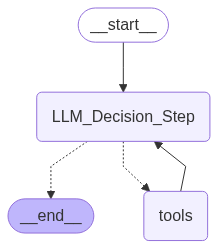

In [105]:
agent.agent_graph

('Let’s get started with your Kyoto adventure! I’ll first check the current '
 'weather and a 5‑day forecast for Kyoto, then look into top attractions, '
 'local dining options (keeping in mind your preference for local food), and '
 'public transportation options. We’ll also explore hotel options that fit '
 'your budget (around $70 per night) and convert that amount to Japanese Yen. '
 'Finally, I’ll estimate an overall cost for your 5‑day trip (including hotel, '
 'food, and activities) and compile a detailed daily plan.\n'
 '\n'
 'Let me begin by checking the current weather and forecast for Kyoto. One '
 'moment…')
